# Initialization

In [1]:
# %load init.ipy
# NOTE: This is for when the notebook is converted to a python script
# NOTE: this MUST precede the magic functions
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))
    
%reload_ext autoreload
%autoreload 2

# %load init.ipy
import os, sys, logging, datetime, warnings, shutil
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import tqdm
import memory_profiler as mpro

import kalepy as kale
import kalepy.utils
import kalepy.plot
from kalepy.plot import nbshow   # NOTE: this should be upgraded to `plot_control`
from kalepy.plot import plot_control

def save_fig(fig, fname, **kwargs):
    kwargs.setdefault('path', kale._PATH_NB_OUT)
    kwargs.setdefault('rename', True)
    return kale.plot._save_fig(fig, fname, **kwargs)

# Generate Random Data

In [2]:
NUM = 30000
# bandwidth = 0.2

sigma = [1.0, 0.2, 1.5]
corr = [
    [+1.0, +0.8, +0.4],
    [+0.8, +1.0, -0.5],
    [+0.2, -0.5, +1.0]
]

s2 = np.square(sigma)

cov = np.zeros_like(corr)
for (ii, jj), cc in np.ndenumerate(corr):
    cov[ii, jj] = cc * sigma[ii] * sigma[jj]

data = np.random.multivariate_normal(np.zeros_like(sigma), cov, NUM).T
dd = data[1, :]
dd = (dd - dd.min())/dd.max()
data *= np.sqrt(dd)[np.newaxis, :]

pc = 0
extr = [np.percentile(dd, [0+pc, 100-pc]) for dd in data]
noise = [np.random.uniform(*ex, NUM//5) for ex in extr]
data = np.append(data, noise, axis=1)

/Users/lzkelley/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: covariance is not positive-semidefinite.


# Data

## Full Corner Plot

med1d - _draw_contours_1d 0.07310248710155513
med1d - _draw_contours_1d 0.03505246167297359
med1d - _draw_contours_1d -0.08355958256395463


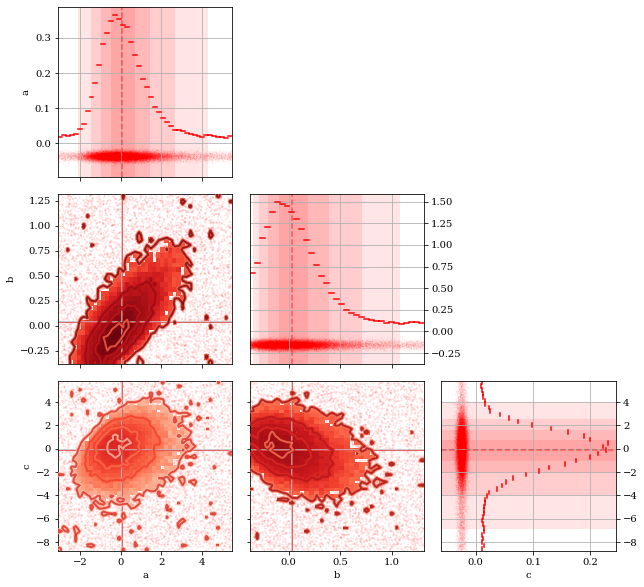

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/corner-test-data_00.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/corner-test-data_00.png'

In [3]:
reload(kalepy.plot)
reload(kalepy.utils)

labels = 'abc'
corner = kale.plot.Corner(figsize=[10, 10], data=data, labels=labels)

edges = None
scatter = True
# scatter = False
smap = dict(log=True)
hist1d = dict(joints=False)
hist2d = dict()
# hist2d = False
contour = dict(linewidths=2.0)
# contour = False

corner.data(color='r', edges=edges, mask_dense=False, mask_sparse=False,
            scatter=scatter, smap=smap, hist1d=hist1d, hist2d=hist2d, contour=contour)

nbshow()
fname = 'corner-test-data.png'
save_fig(corner.fig, fname)

## 1D Distributions

med1d - _draw_contours_1d 0.07310248710155513
med1d - _draw_contours_1d 0.03505246167297359
med1d - _draw_contours_1d -0.08355958256395463


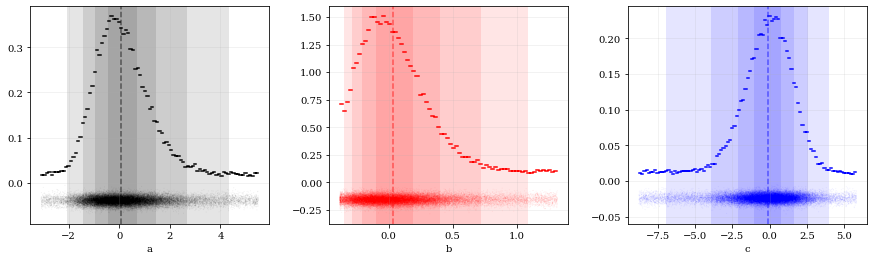

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/corner-test-data-1d.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/corner-test-data-1d.png'

In [4]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

for kk, ax in enumerate(axes):
    ax.grid(True, alpha=0.2)
    col = colors[kk]
    ax.set(xlabel=labels[kk])  
    kale.plot.dist1d_data(ax, data=data[kk], color=col)

nbshow()
fname = 'corner-test-data-1d.png'
save_fig(fig, fname)

## 2D Distributions

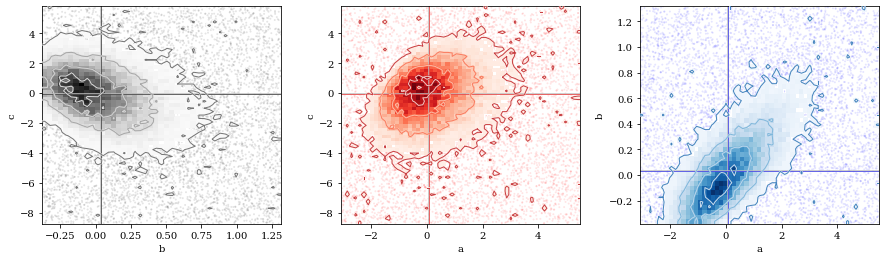

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/corner-test-data-2d.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/corner-test-data-2d.png'

In [5]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

for kk, ax in enumerate(axes):
    col = colors[kk]
    jj = (kk + 1) % 3
    ii = (kk + 2) % 3
    jj, ii = np.sort([jj, ii])
    td = [data[jj], data[ii]]
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    
    kale.plot.dist2d_data(ax, data=td, color=col,
                            mask_dense=True, mask_sparse=True, hist2d=True, density=True)

nbshow()
fname = 'corner-test-data-2d.png'
save_fig(fig, fname)

# KDEs

## Full Corner Plot

med1d
	ee= [-3.31e+00, -3.22e+00, -3.13e+00 ... 5.54e+00, 5.63e+00, 5.73e+00]
	pdf= [1.10e-03, 3.68e-03, 7.39e-03 ... 8.39e-03, 4.30e-03, 1.13e-03]
med1d - _draw_contours_1d 0.07679774521503573
med1d
	ee= [-6.03e-01, -5.81e-01, -5.60e-01 ... 1.50e+00, 1.52e+00, 1.54e+00]
	pdf= [0.00e+00, 0.00e+00, 0.00e+00 ... 0.00e+00, 0.00e+00, 0.00e+00]
med1d - _draw_contours_1d 0.03528922464587531
med1d
	ee= [-8.98e+00, -8.82e+00, -8.67e+00 ... 5.73e+00, 5.88e+00, 6.03e+00]
	pdf= [2.05e-03, 4.26e-03, 7.09e-03 ... 6.60e-03, 4.33e-03, 2.24e-03]
med1d - _draw_contours_1d -0.0872925149769462


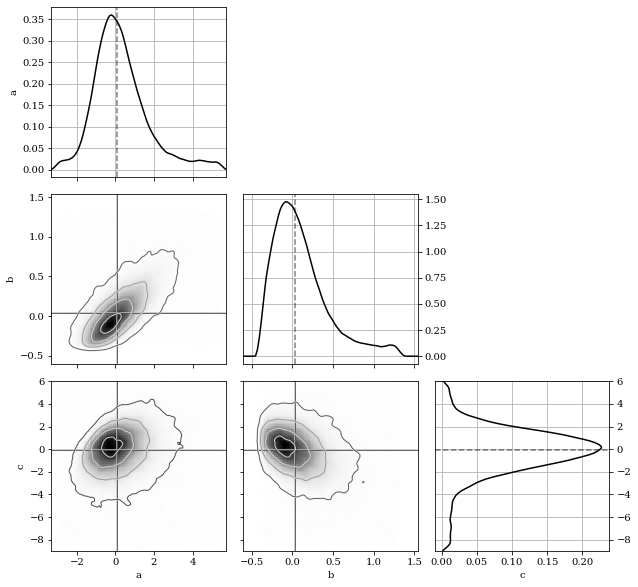

In [6]:
reload(kalepy.plot)
reload(kalepy.utils)

kernel = 'parabola'
# kernel = 'gaussian'
kde = kale.KDE(data, kernel=kernel)
corner = kale.plot.Corner(figsize=[10, 10], kde=kde, labels=labels)
corner.kde(verbose=False)

# fig, axes = plt.subplots(figsize=[15, 15], ncols=3, nrows=3)
# plt.subplots_adjust(wspace=0.25)
# colors = ['k', 'r', 'b']
# kale.plot.corner_kde(axes, kde, verbose=True)

nbshow()

## 1D Distributions

med1d
	ee= [-4.44e+00, -4.33e+00, -4.21e+00 ... 6.62e+00, 6.74e+00, 6.85e+00]
	pdf= [2.07e-07, 9.60e-07, 3.94e-06 ... 4.28e-06, 1.04e-06, 2.24e-07]
med1d - _draw_contours_1d 0.08579726251425782
med1d
	ee= [-1.73e+00, -1.69e+00, -1.64e+00 ... 2.58e+00, 2.62e+00, 2.67e+00]
	pdf= [6.35e-71, 1.78e-66, 3.53e-62 ... 3.46e-63, 1.72e-67, 6.11e-72]
med1d - _draw_contours_1d 0.038206071698342295
med1d
	ee= [-1.01e+01, -9.93e+00, -9.75e+00 ... 6.81e+00, 6.99e+00, 7.16e+00]
	pdf= [4.80e-05, 1.24e-04, 2.88e-04 ... 2.92e-04, 1.28e-04, 5.06e-05]
med1d - _draw_contours_1d -0.09652211342702513


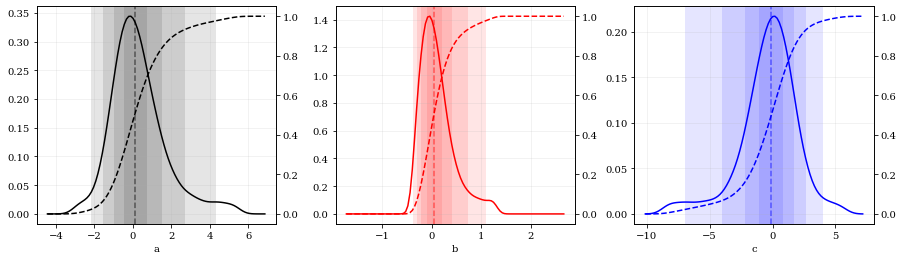

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/corner-test-kde-1d.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/corner-test-kde-1d.png'

In [7]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

kde = kale.KDE(data)

for kk, ax in enumerate(axes):
    ax.grid(True, alpha=0.2)
    col = colors[kk]
    ax.set(xlabel=labels[kk]) 
    kale.plot.dist1d_kde(ax, kde, param=kk, color=col)

nbshow()
fname = 'corner-test-kde-1d.png'
save_fig(fig, fname)

## 2D Distributions

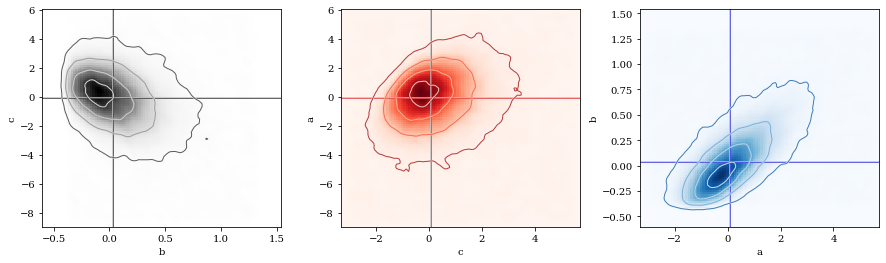

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/corner-test-kde-2d.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/corner-test-kde-2d.png'

In [8]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

kernel = 'parabola'
# kernel = 'gaussian'
kde = kale.KDE(data, kernel=kernel)

for kk, ax in enumerate(axes):
    col = colors[kk]
    jj = (kk + 1) % 3
    ii = (kk + 2) % 3
    params = np.sort([jj, ii])
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    
    kale.plot.dist2d_kde(ax, kde, params=params, color=col)
    
nbshow()
fname = 'corner-test-kde-2d.png'
save_fig(fig, fname)